## Transfer Learning

In [2]:
import tensorflow as tf
import tensorflow.compat.v1 as tf1
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.layers import Dense,Input,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

In [ ]:
body = VGG16(include_top=False,weights='imagenet',input_shape=(32,32,3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
body.trainable = False

In [ ]:
x = Flatten()(body.output)
x = Dense(100,activation='softmax')(x)
model = Model(inputs=body.input,outputs=x)

In [ ]:
from tensorflow.keras.datasets import cifar100
(train_x,train_y),(test_x,test_y) = cifar100.load_data()

169009152/169001437 [==============================] - 5s 0us/step


In [ ]:
test_x.shape

(10000, 32, 32, 3)

In [ ]:
train_x = train_x/255.0
test_x = test_x/255.0

In [ ]:
train_y,test_y = train_y.flatten(),test_y.flatten()

In [ ]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit(train_x,train_y,validation_data=(test_x,test_y),epochs=10)

Epoch 1/10
  97/1563 [>.............................] - ETA: 5:31 - loss: 4.6178 - accuracy: 0.0273

KeyboardInterrupt: ignored

# Face Recognition

In [3]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    ### START CODE HERE ### (≈2 lines)
    X = tf.placeholder(tf.float32, shape = (None, n_H0, n_W0, n_C0), name = "X")
    Y = tf.placeholder(tf.float32, shape = (None, n_y), name = "Y")
    ### END CODE HERE ###
    
    return X, Y

In [4]:

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [4, 4, 3, 8]
                        W2 : [2, 2, 8, 16]
    Returns:
    parameters -- a dictionary of tensors containing W1, W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 2 lines of code)
    W1 = tf.get_variable("W1", [5, 5, 3, 6], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 6, 6], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
   # W3 = tf.get_variable("W2", [5, 5, 6, 16], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
   # W4 = tf.get_variable("W2", [2, 2, 16,16], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "W2": W2,
                  #"W3":W3,
                  #"W4":W4
                  }
    return parameters

In [5]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "W2"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    #W3 = parameters["W3"]
    #W4 = parameters["W4"]
    
    ### START CODE HERE ###
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    #Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None)
    ### END CODE HERE ###

    return P2

In [6]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    ### START CODE HERE ### (≈ 4 lines)
    # Step 1: Compute the (encoding) distance between the anchor and the positive
    pos_dist = tf.reduce_sum(tf.square(anchor-positive),axis=-1)
    # Step 2: Compute the (encoding) distance between the anchor and the negative
    neg_dist = tf.reduce_sum(tf.square(anchor-negative),axis=-1)
    # Step 3: subtract the two previous distances and add alpha.
    basic_loss = pos_dist - neg_dist + alpha
    # Step 4: Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss,0))
    ### END CODE HERE ###
    
    return loss

In [7]:
def initialize_adam(parameters) :
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s. Input: "parameters". Outputs: "v, s".
    for l in range(L):
    ### START CODE HERE ### (approx. 4 lines)
        v["dW" + str(l+1)] = np.zeros_like(parameters["W"+str(l+1)])
        v["db" + str(l+1)] = np.zeros_like(parameters["b"+str(l+1)])
        s["dW" + str(l+1)] = np.zeros_like(parameters["W"+str(l+1)])
        s["db" + str(l+1)] = np.zeros_like(parameters["b"+str(l+1)])
    ### END CODE HERE ###
    
    return v, s

In [8]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients. Inputs: "v, grads, beta1". Output: "v".
        ### START CODE HERE ### (approx. 2 lines)
        v["dW" + str(l+1)] = beta1*v["dW"+str(l+1)] + (1-beta1)*grads["dW"+str(l+1)]
        v["db" + str(l+1)] = beta1*v["db"+str(l+1)] + (1-beta1)*grads["db"+str(l+1)]
        ### END CODE HERE ###

        # Compute bias-corrected first moment estimate. Inputs: "v, beta1, t". Output: "v_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        v_corrected["dW" + str(l+1)] = v["dW"+str(l+1)]/(1-beta1**t)
        v_corrected["db" + str(l+1)] = v["db"+str(l+1)]/(1-beta1**t)
        ### END CODE HERE ###

        # Moving average of the squared gradients. Inputs: "s, grads, beta2". Output: "s".
        ### START CODE HERE ### (approx. 2 lines)
        s["dW" + str(l+1)] = beta2*s["dW"+str(l+1)] + (1-beta2)*(grads["dW"+str(l+1)]**2)
        s["db" + str(l+1)] = beta2*s["db"+str(l+1)] + (1-beta2)*(grads["db"+str(l+1)]**2)
        ### END CODE HERE ###

        # Compute bias-corrected second raw moment estimate. Inputs: "s, beta2, t". Output: "s_corrected".
        ### START CODE HERE ### (approx. 2 lines)
        s_corrected["dW" + str(l+1)] = s["dW"+str(l+1)]/(1-beta2**t)
        s_corrected["db" + str(l+1)] = s["db"+str(l+1)]/(1-beta2**t)
        ### END CODE HERE ###

        # Update parameters. Inputs: "parameters, learning_rate, v_corrected, s_corrected, epsilon". Output: "parameters".
        ### START CODE HERE ### (approx. 2 lines)
        parameters["W" + str(l+1)] = parameters["W"+str(l+1)] - learning_rate*(v_corrected["dW"+str(l+1)]/np.sqrt(s_corrected["dW"+str(l+1)]))
        parameters["b" + str(l+1)] = parameters["b"+str(l+1)] - learning_rate*(v_corrected["db"+str(l+1)]/np.sqrt(s_corrected["db"+str(l+1)]))
        ### END CODE HERE ###

    return parameters, v, s

In [9]:
def backward_propagation_n(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input datapoint, of shape (input size, 1)
    Y -- true "label"
    cache -- cache output from forward_propagation_n()
    
    Returns:
    gradients -- A dictionary with the gradients of the cost with respect to each parameter, activation and pre-activation variables.
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

## Simes Network 

In [10]:
import keras as k
import keras.backend as K
import numpy as np 
from keras.layers import *
from keras.models import Sequential, Model
from keras.regularizers import l2
import matplotlib.pyplot as plt
from keras.optimizers import Adam, Adadelta
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [71]:
(x_train_master, y_train_master), (x_test_master, y_test_master) = k.datasets.cifar10.load_data()
x_train_master = x_train_master /  255
x_test_master = x_test_master / 255
#x_train_master = np.expand_dims(x_train_master, 3)
#x_test_master = np.expand_dims(x_test_master, 3)
print(y_train_master.shape)
y_train_master = y_train_master.flatten()
y_test_master = y_test_master.flatten()


(50000, 1)


In [70]:
y_train_master.shape

(50000,)

In [42]:
num_train_per_class = 1
n_epochs = 10

In [13]:
def generate_triplets(dataset, label, sample_per_class=10):
  x, y = None, None
  for i in range(10):
    pos_indices = np.argwhere(label == i)[:,0]
    neg_indices = np.argwhere(label != i)[:,0]

    # print("pos indices: {}, neg_indices: {}".format(pos_indices.shape, neg_indices.shape))
    choice_anchor = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_anchor = pos_indices[choice_anchor]

    choice_pos = np.random.choice(pos_indices.shape[0], sample_per_class, replace=False)
    choice_pos = pos_indices[choice_pos]

    choice_neg = np.random.choice(neg_indices.shape[0], sample_per_class, replace=False)
    choice_neg = neg_indices[choice_neg]

    sub_x_anc = dataset[choice_anchor]
    
    sub_x_pos = dataset[choice_pos]

    sub_x_neg = dataset[choice_neg]
      
        
    if(x is None):
      x = [(sub_x_anc), (sub_x_pos), (sub_x_neg)]
      y = [label[choice_anchor], label[choice_pos], label[choice_neg]]
    else:
      x[0] = np.vstack((x[0], (sub_x_anc)))
      x[1] = np.vstack((x[1], (sub_x_pos)))
      x[2] = np.vstack((x[2], (sub_x_neg)))

      y[0] = np.hstack((y[0].flatten(), label[choice_anchor].flatten()))
      y[1] = np.hstack((y[1].flatten(), label[choice_pos].flatten()))
      y[2] = np.hstack((y[2].flatten(), label[choice_neg].flatten()))
    
  return x, y

In [67]:
train_x, train_y = generate_triplets(train_generator, train_generator.labels)
train_x[0].shape

AttributeError: ignored

In [15]:
def visualize_data(data, n):
  n = min(len(data[0]), n)
  random_choices = np.random.choice(len(data[0]),n, replace=False)
  fig, ax = plt.subplots(n, 3,figsize=(10,40))
  anc, pos, neg = data
  for i,ch in enumerate(random_choices):
    ax[i, 0].imshow(np.squeeze(anc[ch] ))
    ax[i, 1].imshow(np.squeeze(pos[ch] ))
    ax[i, 2].imshow(np.squeeze(neg[ch] ))
    

    ax[i, 0].set_axis_off()
    ax[i, 1].set_axis_off()
    ax[i, 2].set_axis_off()

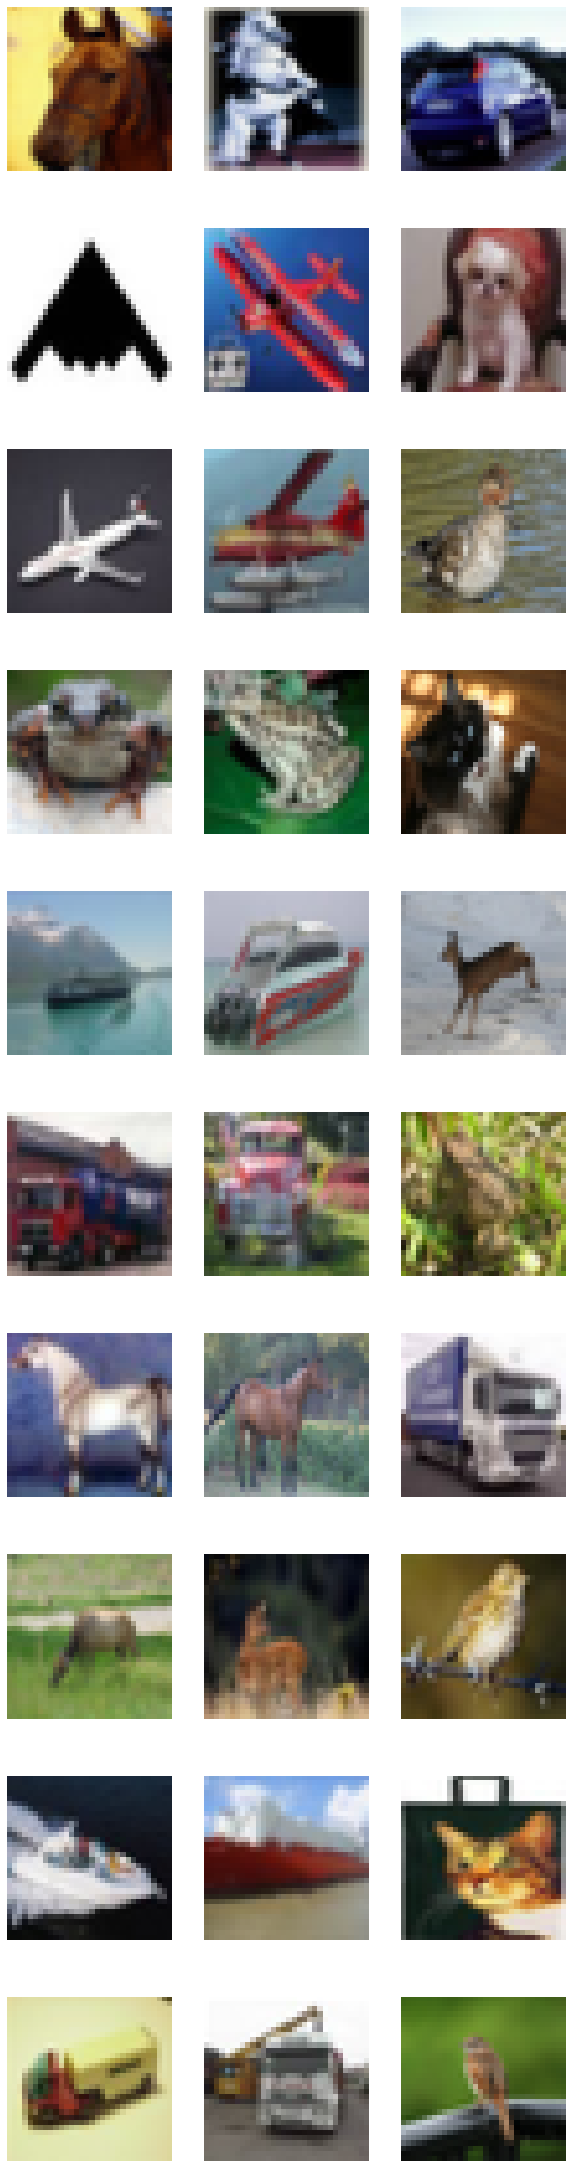

In [46]:
visualize_data(train_x, 10)

In [47]:

train_x, train_y = generate_triplets(x_train_master, y_train_master, num_train_per_class)
test_x, test_y = generate_triplets(x_test_master, y_test_master,5)

In [48]:
def triplet_loss(inputs, dist='sqeuclidean', margin='maxplus'):
    anchor, positive, negative = inputs
    positive_distance = K.square(anchor - positive)
    negative_distance = K.square(anchor - negative)
    if dist == 'euclidean':
        positive_distance = K.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
        negative_distance = K.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    elif dist == 'sqeuclidean':
        positive_distance = K.sum(positive_distance, axis=-1, keepdims=True)
        negative_distance = K.sum(negative_distance, axis=-1, keepdims=True)
    loss = positive_distance - negative_distance
    if margin == 'maxplus':
        loss = K.maximum(0.0, 1 + loss)
    elif margin == 'softplus':
        loss = K.log(1 + K.exp(loss))
    return K.mean(loss)

def get_embedding_model(input_shape, embedding_dim):
    _input = Input(shape=input_shape)
    x = Flatten()(_input)
    x = Dense(embedding_dim * 4,activation="relu")(x)
    x = Dense(embedding_dim * 2, activation='relu')(x)
    x = Dense(embedding_dim)(x)
    return Model(_input, x)

In [49]:
def get_siamese_model(input_shape, triplet_margin=.3, embedding_dim=50):
    """
        Model architecture
    """
    
    # Define the tensors for the triplet of input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input")
    
    # Convolutional Neural Network (same from earlier)
    embedding_model = get_embedding_model(input_shape, embedding_dim)
    
    # Generate the embedding outputs 
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input, positive_input, negative_input]
    outputs = [encoded_anchor, encoded_positive, encoded_negative]
    
    # Connect the inputs with the outputs
    siamese_triplet = Model(inputs=inputs,outputs=outputs)
    
    siamese_triplet.add_loss((triplet_loss(outputs, dist='euclidean', margin='maxplus')))
    
    # return the model
    return embedding_model, siamese_triplet

In [50]:
embedding_model, siamese_triplet = get_siamese_model((32,32,3), triplet_margin=.3, embedding_dim=150)
siamese_triplet.compile(loss=None, optimizer=Adam(0.0001))

In [62]:
from tensorflow.keras.datasets import cifar10
(train_x,train_y),(test_x,test_y) = cifar10.load_data()
train_x = train_x/255.0
test_x = test_x/255.0
train_y,test_y = train_y.flatten(),test_y.flatten()
batch_size = 32
generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = generator.flow(train_x,train_y, batch_size)
steps_per_epoch = train_x.shape[0] // batch_size

In [65]:

history = siamese_triplet.fit(x=train_x, shuffle=True, batch_size=1000,
                              validation_split=.1, epochs=50)

Epoch 1/50


ValueError: ignored

In [66]:
siamese_triplet.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
anchor_input (InputLayer)       [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
positive_input (InputLayer)     [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
negative_input (InputLayer)     [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 150)          2069250     anchor_input[0][0]               
                                                                 positive_input[0][0]       

In [ ]:
embedding_model.predict()

In [54]:
train_embeds = embedding_model.predict(np.vstack((train_x[0], train_x[1], train_x[2])))

In [55]:
target = np.hstack((train_y[0], train_y[1], train_y[2]))

In [38]:
train_embeds.shape

(30, 150)

In [26]:
target.shape

(30,)

In [56]:
from sklearn.neighbors import KNeighborsClassifier
def fit_nearest_neighbor(img_encoding, img_class, algorithm='ball_tree'):
  classifier = KNeighborsClassifier(n_neighbors=3, algorithm=algorithm)
  classifier.fit(img_encoding, img_class)
  return classifier
classifier = fit_nearest_neighbor(train_embeds, target)
e = embedding_model.predict(x_test_master)
op = classifier.predict(e)

In [58]:
(np.where(y_test_master != op))[0].shape[0] / y_test_master.shape[0]

0.847

In [59]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_master, op)

In [60]:

mat.diagonal()

array([518, 184, 449,  77,  27,  73,  65,   0,  83,  54])

In [27]:
pred = embedding_model.predict(x_test_master)

In [28]:
pred = np.argmax(pred,axis=1)

In [29]:
pred

array([126, 100,  97, ...,  81,  97, 140])

In [31]:
y_test_master

array([9, 2, 1, ..., 8, 1, 5], dtype=uint8)